# 日本語テキスト分析のデモ

日本語のテキストを形態素解析で単語に分解し、クロス集計表に基づく対応分析とワードクラウド描画を行う。

In [3]:
# japanize_matplotlibなどが未インストール状態の場合に、コメント解除して本セルを単独で実行する（先頭に!が必要）
#!pip install japanize-matplotlib
#!pip install janome
#!pip install mca
#!apt-get -y install fonts-ipafont-gothic

In [4]:
# Googleドライブをマウントする場合、２行のコメント解除して本セルを単独で実行する
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font=['IPAexGothic'])
import japanize_matplotlib # matplotlib日本語
from google.colab import files # 画像ファイルダウンロード用

長岡市のイベントデータを例題として用いる

In [6]:
# tsvファイルからデータを読み込む
col_name = ['event_id','ch_month','event_title','latitude','longitude','ch_date','ch_venue']
df01 = pd.read_table('/content/drive/My Drive/Colab Notebooks/nagaoka_event.tsv',header=None,names=col_name)
df01.head()

,event_id,ch_month,event_title,latitude,longitude,ch_date,ch_venue
0,event 1,4月,新規採用職員辞令交付式,37.6368,138.961691,4/1(木)08:30～-:-,新潟県三条市旭町2-3-1 三条市役所本庁舎 大会議室
1,event 2,4月,国派遣等職員帰任報告,37.6368,138.961691,4/1(木)09:15～-:-,新潟県三条市旭町2-3-1 三条市役所本庁舎 市長室
2,event 3,4月,再任用職員辞令交付式,37.6368,138.961691,4/1(木)09:30～-:-,新潟県三条市旭町2-3-1 三条市役所本庁舎 大会議室
3,event 4,4月,三条地域水道用水供給企業団辞令交付式,37.6368,138.961691,4/1(木)09:50～-:-,新潟県三条市旭町2-3-1 三条市役所本庁舎 市長室
4,event 5,4月,市立大学職員辞令交付式,37.6368,138.961691,4/1(木)10:00～-:-,新潟県三条市旭町2-3-1 三条市役所本庁舎 市長室


In [7]:
df01.shape

(533, 7)

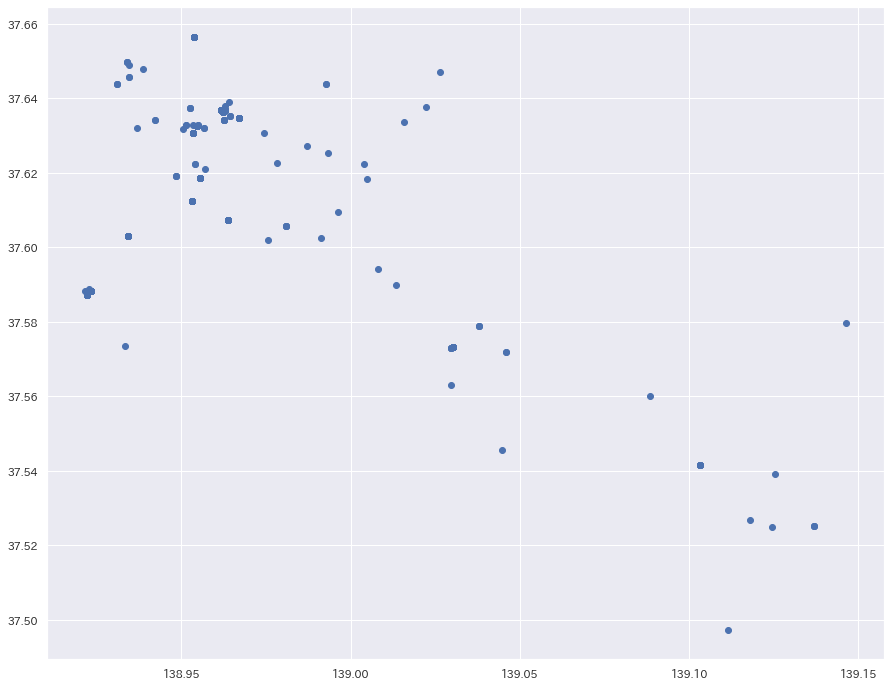

In [8]:
# 緯度経度をプロットする
import matplotlib.pyplot as plt
plt.figure(figsize=(15,12))
plt.scatter(df01['longitude'], df01['latitude'], c='b',marker='o')

In [9]:
# 列を絞り込む
df01.drop(columns=['latitude','longitude','ch_venue'],inplace=True)

ライブラリ"janome"を用いて形態素解析を行う

In [10]:
# わかち書き関数
from janome.tokenizer import Tokenizer
def wakachi(text):
  t = Tokenizer()
  tokens = t.tokenize(text)
  docs = []
  for token in tokens:
    docs.append(token.surface)
  return docs

# 文書ベクトル化関数
from sklearn.feature_extraction.text import TfidfVectorizer
def vecs_array(documents):
  docs = np.array(documents)
  vectorizer = TfidfVectorizer(analyzer=wakachi, binary=True, use_idf=False)
  vecs = vectorizer.fit_transform(docs)
  return vecs.toarray()

In [11]:
# イベントタイトルを単語に分割する
df11 = df01.assign(event_words=df01['event_title'].apply(wakachi))
df11.head()

,event_id,ch_month,event_title,ch_date,event_words
0,event 1,4月,新規採用職員辞令交付式,4/1(木)08:30～-:-,"[新規, 採用, 職員, 辞令, 交付, 式]"
1,event 2,4月,国派遣等職員帰任報告,4/1(木)09:15～-:-,"[国, 派遣, 等, 職員, 帰任, 報告]"
2,event 3,4月,再任用職員辞令交付式,4/1(木)09:30～-:-,"[再, 任用, 職員, 辞令, 交付, 式]"
3,event 4,4月,三条地域水道用水供給企業団辞令交付式,4/1(木)09:50～-:-,"[三条, 地域, 水道, 用水, 供給, 企業, 団, 辞令, 交付, 式]"
4,event 5,4月,市立大学職員辞令交付式,4/1(木)10:00～-:-,"[市立, 大学, 職員, 辞令, 交付, 式]"


In [12]:
# リスト内の要素を縦方向に展開する
df21 = df11.explode('event_words')
df21.head()

,event_id,ch_month,event_title,ch_date,event_words
0,event 1,4月,新規採用職員辞令交付式,4/1(木)08:30～-:-,新規
0,event 1,4月,新規採用職員辞令交付式,4/1(木)08:30～-:-,採用
0,event 1,4月,新規採用職員辞令交付式,4/1(木)08:30～-:-,職員
0,event 1,4月,新規採用職員辞令交付式,4/1(木)08:30～-:-,辞令
0,event 1,4月,新規採用職員辞令交付式,4/1(木)08:30～-:-,交付


In [13]:
# キーワードが全角で2文字以上に限定する
import unicodedata
df22 = df21.assign(ret=df21['event_words'].apply(lambda x: unicodedata.east_asian_width(x[0])))
df23 = df22.assign(w_len=df22['event_words'].apply(lambda x: len(x)))
df24 = df23.query('ret=="W" & w_len>=2')
df24.head()

,event_id,ch_month,event_title,ch_date,event_words,ret,w_len
0,event 1,4月,新規採用職員辞令交付式,4/1(木)08:30～-:-,新規,W,2
0,event 1,4月,新規採用職員辞令交付式,4/1(木)08:30～-:-,採用,W,2
0,event 1,4月,新規採用職員辞令交付式,4/1(木)08:30～-:-,職員,W,2
0,event 1,4月,新規採用職員辞令交付式,4/1(木)08:30～-:-,辞令,W,2
0,event 1,4月,新規採用職員辞令交付式,4/1(木)08:30～-:-,交付,W,2


In [19]:
# イベント単語の出現頻度を求める
import pprint
col_name = 'event_words'
import collections
c_count = collections.Counter(df24[col_name])
pprint.pprint(c_count, compact=True)

Counter({'教室': 75,
         '三条': 54,
         '入門': 49,
         '委員': 39,
         '将棋': 21,
         '講座': 21,
         '健康': 20,
         'ピンポン': 19,
         'まちなか': 18,
         '令和': 18,
         '書道': 18,
         '縁台': 17,
         '会議': 17,
         '作ろ': 17,
         '体操': 17,
         '初心者': 16,
         '体験': 16,
         '市長': 15,
         '総会': 15,
         '作り': 14,
         'おじ': 13,
         'フリー': 13,
         '卓球': 13,
         '大学': 12,
         '定例': 12,
         '記念': 12,
         '市民': 12,
         '交付': 11,
         '議会': 11,
         'づくり': 11,
         '農業': 11,
         'セミナー': 11,
         'ゼミ': 11,
         '辞令': 10,
         '年度': 10,
         'スパイス': 10,
         'カレー': 10,
         '作り方': 10,
         'ハンド': 10,
         '楽しむ': 10,
         '相談': 10,
         '下田': 10,
         'やさしい': 10,
         '大人': 10,
         'ヨガ': 9,
         '周年': 9,
         'スマホ': 9,
         '女性': 9,
         '協議': 8,
         '細工': 8,
         'かわいい': 8,
         'メイド': 8,

月とキーワードのクロス集計表から対応分析を行う

In [14]:
# クロス集計
df31 = pd.crosstab(df24['ch_month'],df24['event_words'])
df31.head(12)

event_words,あり,いきいき,いちい,いちご,いっぷく,いのち,えん,おいしい,おこわ,おじ,おぞ,おだやか,おとな,おれん,お出かけ,お寺,お披露目,お茶,かご,かじ,から,かわいい,かわいく,きっ,くらぶ,けん玉,こころ,ことぶき,こども,ごと,ごはん,さかえ,さわやか,さん,さんじょ,した,しぶ,しよ,しらべ,すべて,...,道路,遠足,選手,選手権,遺産,遺跡,部会,部長,郵便,醤油,野球,野菜,金属,鉛筆,鑑賞,開会,開始,開幕,開業,開発,関係,防災,除幕,集団,電力,面識,音楽,響き,顧問,風鈴,飲ん,飾り,養成,養護,首長,香る,高齢,魅力,黒い,黙とう
ch_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4月,0,0,0,0,1,0,1,0,0,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
5月,1,0,1,1,0,0,0,0,1,3,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,0,1,0,0,0,...,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0
6月,1,0,1,0,0,1,0,0,0,3,0,1,1,0,2,0,0,0,4,0,2,4,0,0,1,2,0,1,1,1,0,0,1,0,0,0,1,1,0,1,...,0,0,0,0,1,0,1,0,0,0,0,2,0,0,0,0,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0
7月,0,1,1,0,0,0,0,2,0,3,0,1,4,0,0,1,0,3,4,0,3,4,1,1,0,1,0,1,1,1,0,0,1,0,2,0,1,0,1,0,...,0,1,2,1,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,1
8月,0,0,1,0,0,0,0,0,0,2,0,0,2,0,0,0,1,3,0,0,1,0,0,2,1,1,0,1,0,1,1,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,2,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,1,0,0


In [15]:
# 対応分析
import mca
import matplotlib.pyplot as plt

mca_counts = mca.MCA(df31)
rows = mca_counts.fs_r(N=2)
cols = mca_counts.fs_c(N=2)

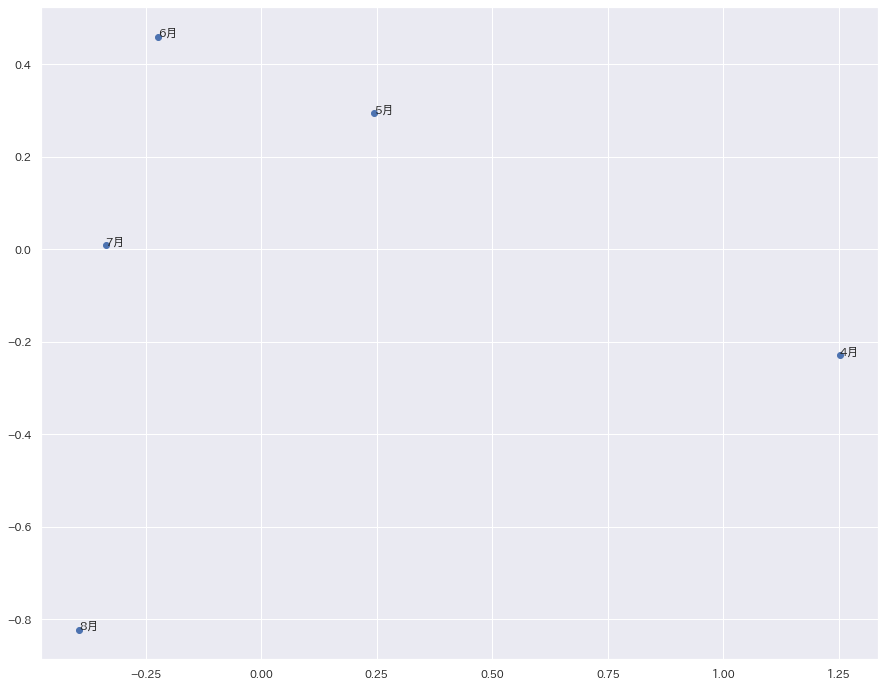

In [16]:
plt.figure(figsize=(15,12))
plt.scatter(rows[:,0], rows[:,1], c='b',marker='o')
labels = df31.index
for label,x,y in zip(labels,rows[:,0],rows[:,1]):
    plt.annotate(label,xy = (x, y))

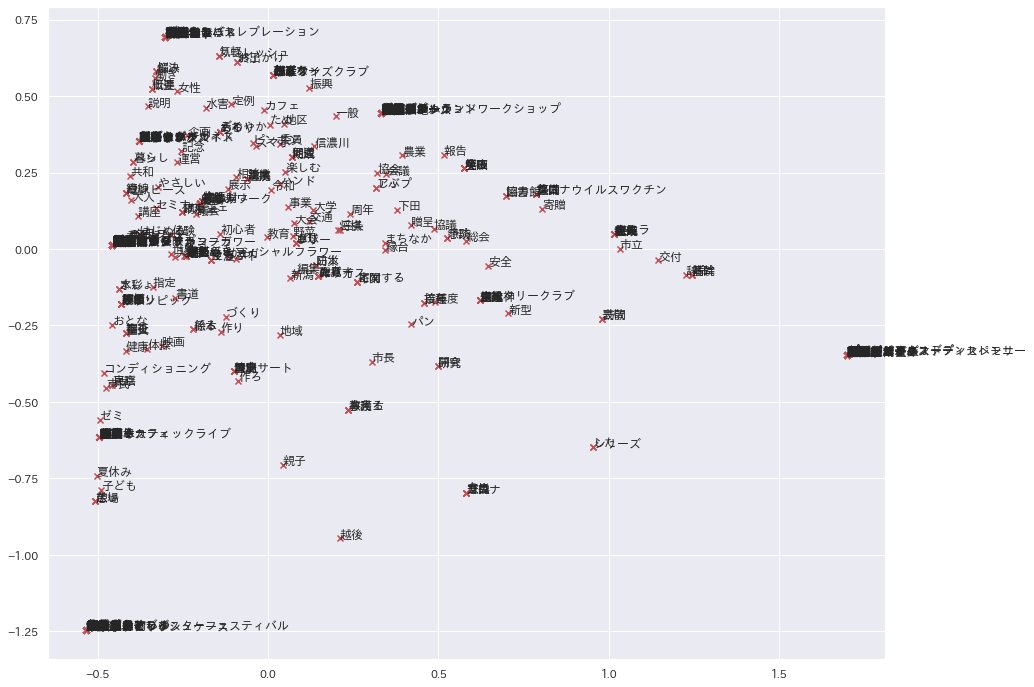

In [17]:
plt.figure(figsize=(15,12))
plt.scatter(cols[:,0], cols[:,1], c='r',marker='x')
labels = df31.columns
for label,x,y in zip(labels,cols[:,0],cols[:,1]):
    plt.annotate(label,xy = (x, y))

イベントタイトルからワードクラウドを作成する

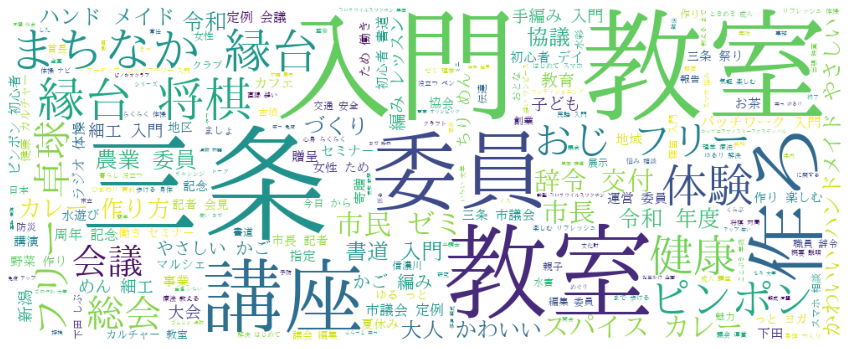

In [18]:
#ワードクラウドの作成
from wordcloud import WordCloud
# 入力用に出現した全単語を半角スペースを介してつなげて一つの文字列とする
word = ''
for irow in range(len(df24)):
  word += df24['event_words'].iloc[irow] + ' '
wordcloud = WordCloud(font_path = '/usr/share/fonts/truetype/fonts-japanese-mincho.ttf',
                      background_color="white",
                      width=1000,height=400).generate(word)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("word_cloud.png")